In [105]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier


In [45]:
def taiga_to_df(dir_path, rubric_list=[]):
    meta_df = pd.read_csv('{}/newmetadata.csv'.format(dir_path))
    if len(rubric_list) > 0:
        meta_df = meta_df[meta_df['textrubric'].apply(lambda x: True if x in rubric_list else False)]
    text_arr = []
    for text_id in meta_df['textid'].values:
        with open('{}/texts/{}.txt'.format(dir_path, text_id)) as f:
            text = f.read()
            text_arr.append(text)

    df = pd.DataFrame()
    df['text'] = text_arr
        
    return df


def chat_to_df(dir_path):
    meta = pd.read_csv('{}/newmetadata.csv'.format(dir_path), sep='\t')
    meta = meta[meta['languages']=='ru']
    meta['filepath'] = meta['filepath'].apply(lambda x: '{}/{}'.format(x.split(' - ')[0].strip(), x))

    text_arr = []
    for text_path in meta['filepath']:
        try:
            with open('{}/texts/{}'.format(dir_path, text_path)) as f:
                text = ' '.join(pd.read_csv('{}/texts/{}'.format(dir_path, text_path), sep='	', header=None)[:-3][3].values)
                text = text.replace('- ', '')
                text = text.replace('<i>', '')
                text = text.replace('</i>', '')
                text_arr.append(text)
        except:
            None
            
    df = pd.DataFrame()
    df['text'] = text_arr
    
    return df

In [299]:
tech_df = taiga_to_df('NPlus1', ['Технологии',  'Транспорт', 'Гаджеты', 'Наука',
                       'Космос', 'Информационные технологии',
                       'Физики смогли', 'Роботы и дроны', 'Персональная геномика',
                       'Коллайдер', 'Обучение машин', 'Мезонин', 'Вакансии',
                       'Органическое на 100% ', 'Партнерский материал',
                       'Разное', 'Вулканы и землетрясения',
                       'Генетика', 'Политех', 'Второй сезон Коллайдера'])

proza_df = taiga_to_df('proza_ru', ['миниатюры', 'рассказы', 'ироническая проза',
       'приключения', 'повести', 'юмористическая проза','стихи',
       'детское творчество', 'новеллы', 'эротическая проза',
       'стихотворения в прозе', 'романы',
       'фантастика', 'сказки', 'мистика', 'мемуары', 'фельетоны',
       'детективы', ' дай молока', ' когда-то', 'литература для детей', 
       'рассказы о детях', 'драматургия', 'ужасы', 'литературные переводы'])

stihi_df = taiga_to_df('stihi_ru')

chat_df = chat_to_df('chat_bot_training')

tech_df['class'] = 0
proza_df['class'] = 1
stihi_df['class'] = 1
chat_df['class'] = 2


df = pd.concat([tech_df, proza_df, stihi_df, chat_df])
df.index = range(len(df))

In [311]:
df['processed_text'] = df['text'].apply(lambda x: x.lower().replace('*', '').replace('\n', ' ').strip())
df['processed_text'] = df['processed_text'].apply(lambda x: x[:500])


In [312]:
hw = HashingVectorizer(n_features=200).fit(df['processed_text'])
X = pd.DataFrame(hw.transform(df['processed_text']).todense())

In [313]:
tfidf = TfidfTransformer()
tfidf.fit(X)

X = pd.DataFrame(tfidf.transform(X).todense())

In [314]:
df['fold'] = np.nan
fold_id = 0
skf = StratifiedKFold(5)
for itr, ite in skf.split(df, df['class']):
    df.loc[ite, 'fold'] = fold_id
    fold_id += 1

In [315]:
scores = []
for fold_id in range(5):
    model = LGBMClassifier()
    model.fit(X[df['fold'] != fold_id], df[df['fold'] != fold_id]['class'])
    
    pred = model.predict(X[df['fold'] == fold_id])
    acc = accuracy_score(df[df['fold'] == fold_id]['class'], pred)
    scores.append(acc)

scores = np.array(scores)
print('{} +- {}'.format(scores.mean(), scores.std()))

0.8862140040547871 +- 0.0302691297951493


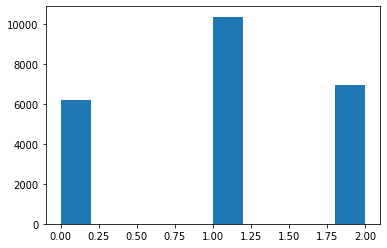

In [322]:
import matplotlib.pyplot as plt
plt.hist(df['class'])
plt.show()

# Inference

In [328]:
text = 'Представьте, что вы работаете над программой текстового редактора. Дело как раз подошло к разработке панели управления. Вы создали класс красивых Кнопок и хотите использовать его для всех кнопок приложения, начиная от панели управления, заканчивая простыми кнопками в диалогах.'
#text = ''
text = text.lower().replace('*', '').replace('\n', ' ').strip()
model.predict_proba(tfidf.transform(hw.transform([text]).todense()).todense())

array([[0.49999089, 0.29589586, 0.20411325]])